<a target="_blank" href="https://colab.research.google.com/github/heechul/EmbeddedML/blob/main/l5-vww/train.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# Mask-Detection using Transfer Learning
In this assignment you will use transfer learning to detect if the person is wearing a mask or not. We will use a pre-trained model (MobileNet-V2) trained on the ImageNet dataset and use a modified version of [kaggle mask dataset](https://www.kaggle.com/prasoonkottarathil/face-mask-lite-dataset) to preform transfer learning.

Remember, a pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this assignment, you will customize a pretrained model in two ways:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.


You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model

**Acknowledgements**

This colab is heavily inspired from the [Google's Transfer learning](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb) Colab.


In [5]:
# Mask-detection assignment/module development
# Copyright (c) 2023 Heechul Yun
# Copyright (c) 2020 Srivatsan Krishnan
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [6]:
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install --upgrade --no-cache-dir gdown


503.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
510.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
516.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
522.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

RunningInCOLAB = 'google.colab' in str(get_ipython())

## Build the dataset

### Download the dataset
You will use a dataset containing several hundreds images of person with and without mask. First you will download and extract a zip file containing the images. Then  you will create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [8]:
import os
if os.stat("edx_transfer_learningv3.zip").st_size != 0:
    print("edx_transfer_learningv3.zip already exists") 
else:
    !gdown --id 1lYOgCLLJU8TCIeTxJHkjsxBq_GPzQYb9
    print("edx_transfer_learningv3.zip downloaded")

if not os.stat("edx_transfer_learningv3"): 
    !unzip edx_transfer_learningv3.zip
    print("edx_transfer_learningv3.zip unzipped")

edx_transfer_learningv3.zip already exists


In [9]:
topdir = os.getcwd()
if not os.stat('model'):
    os.mkdir('model')
if not os.stat('src'):
    os.mkdir('src')
print(topdir)

/Users/h488y928/Teaching/EmbeddedML/l5-vww


In [10]:
path_to_zip = topdir
print(path_to_zip)
PATH = os.path.join(path_to_zip, 'edx_transfer_learningv3/edx_transfer_learning/')
print(PATH)
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

/Users/h488y928/Teaching/EmbeddedML/l5-vww
/Users/h488y928/Teaching/EmbeddedML/l5-vww/edx_transfer_learningv3/edx_transfer_learning/
Found 602 files belonging to 2 classes.


In [11]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Now that we have built the dataset lets view the first nine images and labels from the training set:

['with_mask', 'without_mask']


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


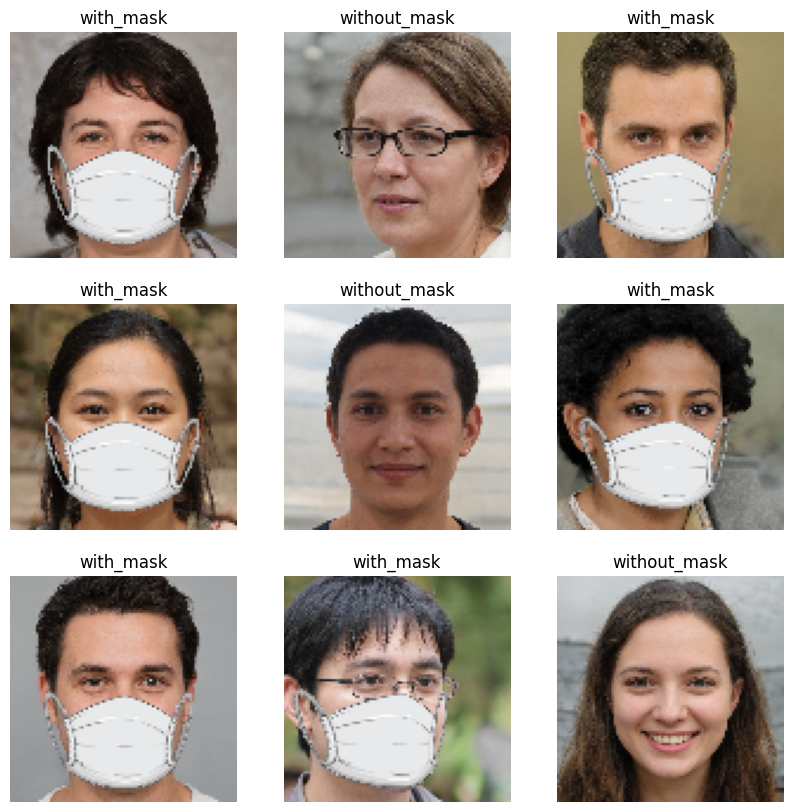

In [12]:
class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split the dataset

As the original dataset doesn't contains a test set, you need to create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation
As we have explored earlier in this specialization, if you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images to expand the dataset. For example, you could apply rotations or flip the data horizontally. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training (when you call `model.fit`). They are inactive when the model is used in inference mode (`model.evaluate` or `model.predict`).

Let's repeatedly apply these layers to the same image and see the result to better understand why this augmentation can help the dataset generalize its learning.

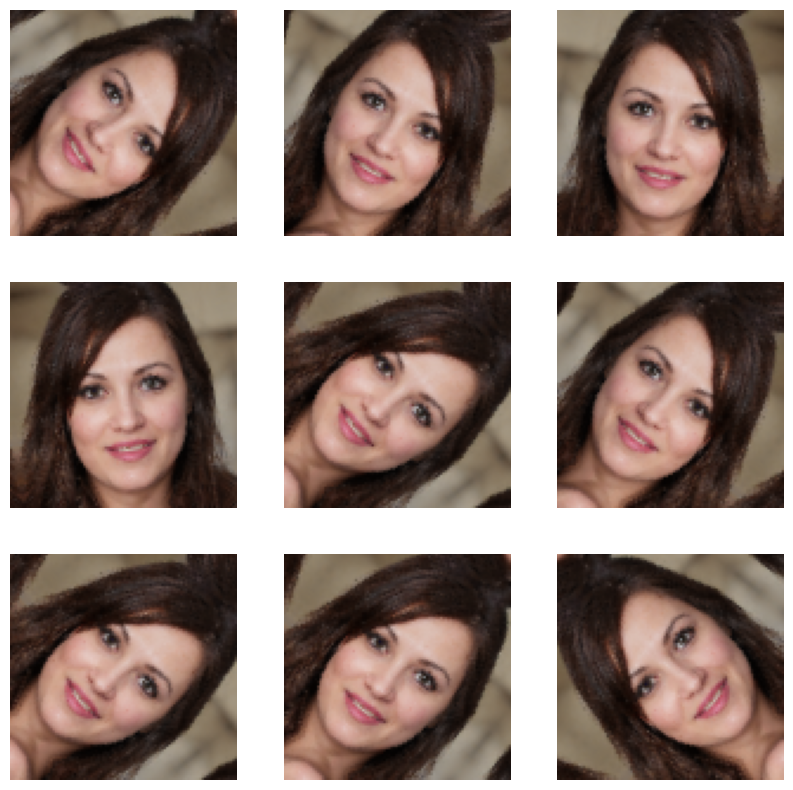

In [17]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [19]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Note: If you go on to use other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Build the Model

### Create the base model
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories including objects such as `jackfruit` and `syringe`. This base of knowledge will help us classify if a person is wearing a mask or not from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will leverage as the high level features you wish to re-use. Since we want to adapt the classifications coming out of the model to a new task, we want to leverage the features coming out of the *last* layer BEFORE the classification layers. In many image models this is the output of the final convolution BEFORE the flatten layer. You may see this layer referred to as the "bottleneck layer" in some texts. Since many machine learning models are defined as the inputs occuring at the bottom and the outputs occuring at the top we would like to ignore the top few classification layers. Fortuntately, there is a shortcut to doing this in TensorFlow, **```include_top=False```**. By passing in this parameter we instantiate a MobileNet V1 model pre-loaded with weights trained on ImageNet that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha=0.35,
                                               weights='imagenet')

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


### Freeze the convolutional layers

It is important to freeze the convolutional layers before you compile and train the model with transfer learning. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. We want to perform this operation because we want to leverage the pre-trained values in the convolutional layers and only learn new classification layer values. We can do this by setting the entire model's `trainable` flag to False.

In [22]:
base_model.trainable = False

In [23]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 16)           432       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 16)           0         ['bn_Conv1[0

### Add a classification head

To begin the process of generating classifications from the pretrained features, we use a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the 3x3 spatial features into a single 1024-element feature vector per image.

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


We then apply a `tf.keras.layers.Dense` layer to convert the feature vector into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [25]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


We can then build our final model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Importantly we remind Tensorflow that we do not want to train the base_model!

In [26]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output. You can see below how we have included the Mobilenet V1 model after the input layer and before our classification layers!

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)        410208    
 ional)                                                          
                                                             

## Your Turn: Train and Evaluate the model

Now that we have our model we can train it! You will see that since we are leveraging all of the pre-trained features we can improve our model from a random initialization (accuracy of ~50%) to a model with over 95% accuracy quite quickly. **How many epochs do you think we'll need?**

### Train the model
First print the initial accuracy

In [29]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 7s 105ms/step - loss: 0.8804 - accuracy: 0.2649
initial loss: 0.88
initial accuracy: 0.26


**Now its your turn to pick the number of epochs of training! Remmeber we are aiming for at least 95% accuracy on the test set!**

*Hint: Despite the fact that it would take more than a day to train this model from scratch, it requires far fewer epochs to train it with transfer learning than you might suspect! You probably have more fingers and toes than the number of epochs you will need!*

In [30]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10


19/19 [==============================] - 12s 337ms/step - loss: 0.7529 - accuracy: 0.4967 - val_loss: 0.7471 - val_accuracy: 0.4728
Epoch 2/10
19/19 [==============================] - 7s 326ms/step - loss: 0.6677 - accuracy: 0.6030 - val_loss: 0.6165 - val_accuracy: 0.6832
Epoch 3/10
19/19 [==============================] - 7s 317ms/step - loss: 0.5765 - accuracy: 0.7093 - val_loss: 0.5118 - val_accuracy: 0.8329
Epoch 4/10
19/19 [==============================] - 7s 322ms/step - loss: 0.4823 - accuracy: 0.8073 - val_loss: 0.4266 - val_accuracy: 0.9282
Epoch 5/10
19/19 [==============================] - 7s 326ms/step - loss: 0.4241 - accuracy: 0.8671 - val_loss: 0.3631 - val_accuracy: 0.9616
Epoch 6/10
19/19 [==============================] - 7s 339ms/step - loss: 0.3703 - accuracy: 0.9037 - val_loss: 0.3101 - val_accuracy: 0.9839
Epoch 7/10
19/19 [==============================] - 7s 319ms/step - loss: 0.3211 - accuracy: 0.9402 - val_loss: 0.2697 - val_accuracy: 0.9901
Epoch 8/10
19/19

Did you hit you accuracy goal? Did you overshoot and spend some extra time training? When might you have been able to quit? Lets take a look at the learning curves of the training and validation accuracy/loss to analyze our results.

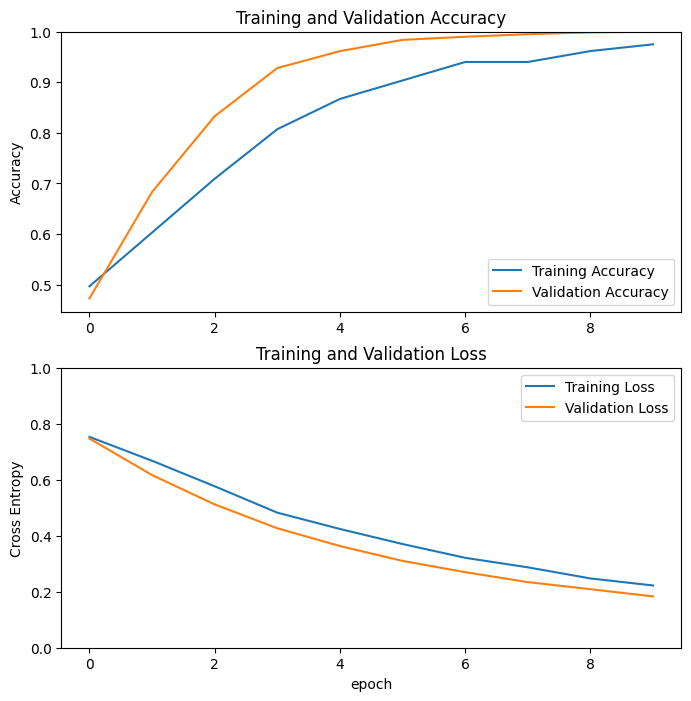

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate your model

The last thing we need to do is check if the model is overfitting or if it actually learned the problem that fast! Does you model still perform well on the test set? Lets find out!

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 136ms/step - loss: 0.1931 - accuracy: 1.0000
Test accuracy : 1.0


And assuming your model passed the accuracy threshold you are now are all set to use this model to predict if the person is wearing a mask or not. Lets print the results from a bunch of the images in our test dataset!


[0.08703198 0.8330003  0.8311677  0.87468743 0.11102215 0.900363
 0.7972494  0.04633167 0.73408693 0.08087482]
Predictions:
 [0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1]
Labels:
 [0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1]


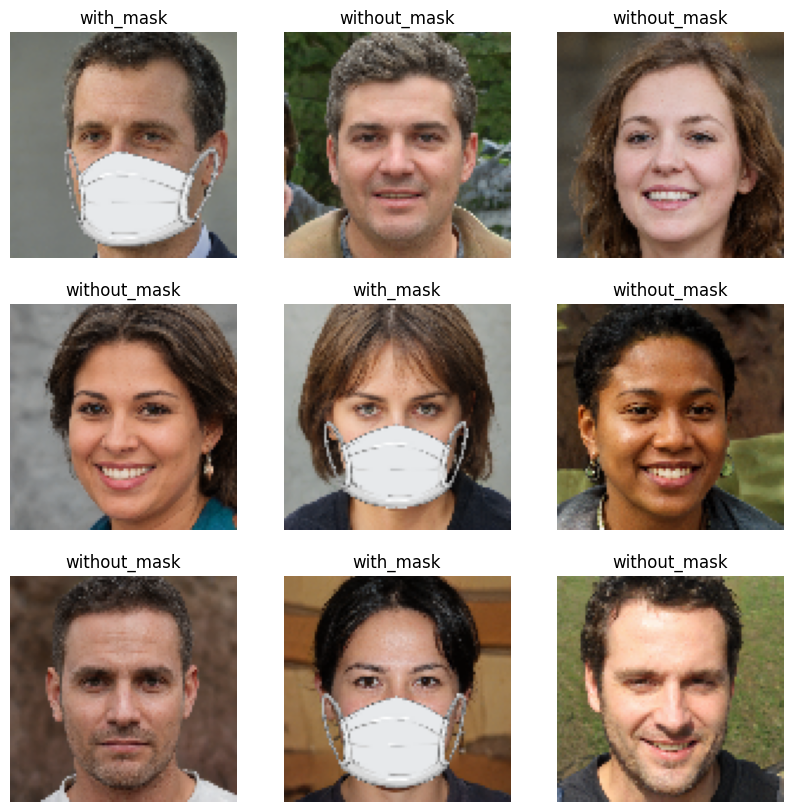

In [33]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

print (predictions[:10]) # logit
# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions) 
# print (predictions[:10])
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using transfer learning for Mask Detection**: In this lab, we learned how we can use transfer learning to detect if a person is wearing mask or not. When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain.



# Model conversion

## Original float model

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic range quantization. size reduction but computing is done in fp32
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('model/model-float32.tflite')
tflite_model_file.write_bytes(tflite_model)



INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp0tsqg4em/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp0tsqg4em/assets
2023-11-22 09:47:32.144893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-22 09:47:32.144909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-22 09:47:32.145231: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp0tsqg4em
2023-11-22 09:47:32.157743: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-22 09:47:32.157756: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp0tsqg4em
2023-11-22 09:47:32.184823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-22 09:47:32.198930: I tensorflow/cc/saved_model/load

548824

## Quantized model

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  

def representative_data_get():
    for input_value, _ in test_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_get
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path('model/model-int8.tflite')
tflite_model_quant_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmptm28o_5n/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmptm28o_5n/assets
/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-11-22 09:48:43.558524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-22 09:48:43.558540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-22 09:48:43.558746: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmptm28o_5n
2023-11-22 09:48:43.573054: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-22 09:48:43.573067: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmptm28o

623576

## Inference

In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
img = image_batch[0,:,:,:]
print (img.flatten())

# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const float img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')



[155.97221 157.83334 141.80556 ... 118.02779 151.33337 158.50006]


In [37]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
interpreter.invoke()
output = interpreter.get_tensor(output_index)
print(output.flatten())
if output.flatten()[0] < 0.5:
    print("Mask")
else:
    print("No Mask")

[0.234375]
Mask


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(96, 96, 3)
[155 157 141]
[155.97221 157.83334 141.80556]


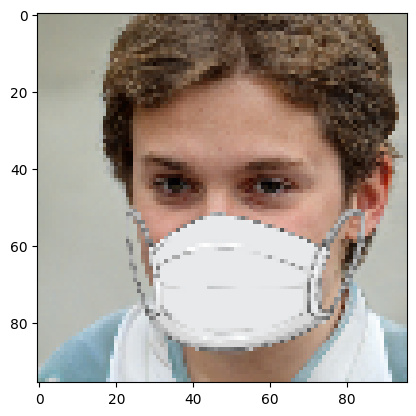

In [38]:
plt.imshow(img.astype("uint8"))
print(img.astype("uint8").shape)
print(img.astype("uint8").flatten()[:3])
print(img.astype("float32").flatten()[:3])

In [39]:
from tqdm import tqdm

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []

    for test_image, test_label in tqdm(test_dataset):
        for i in range(len(test_label)):
            interpreter.set_tensor(input_index, np.expand_dims(test_image[i], axis=0))
            interpreter.invoke()
            prediction_digits.append(interpreter.get_tensor(output_index))
            test_labels.append(test_label[i])
    prediction_digits = np.array(prediction_digits).flatten()
    print(prediction_digits[:10])
    test_labels = np.array(test_labels)
    print(test_labels[:10])
    prediction_digits = np.where(prediction_digits < 0.5, 0, 1)
    print(prediction_digits[:10])

    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Float model accuracy = ', test_accuracy)

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Quantized model accuracy = ', test_accuracy)


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


[0.7082317  0.09914462 0.086358   0.14312063 0.73613256 0.13859029
 0.09615697 0.08445954 0.16655312 0.73107296]
[1 0 0 0 1 0 0 0 0 1]
[1 0 0 0 1 0 0 0 0 1]
Float model accuracy =  1.0


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

[0.109375   0.58203125 0.8515625  0.78515625 0.76171875 0.9140625
 0.85546875 0.23828125 0.84375    0.40234375]
[0 1 1 1 1 1 1 0 1 0]
[0 1 1 1 1 1 1 0 1 0]
Quantized model accuracy =  0.9947916666666666


## Generate model CC file

In [40]:
model_file = 'model-int8'
!xxd -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" | sed "s/model_model_int8_tflite/gmodel/g"> src/model.cc
# !xxd -n gmodel -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" > src/model.cc

777.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
